In [1]:
import sys
sys.path.append("./scripts/")
from gridmap import *
import math
import copy
from matplotlib.animation import PillowWriter    #アニメーション保存用
neigbor_grids = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
theta_neigbors = np.array([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi, -3 * np.pi / 4, -np.pi / 2, -np.pi / 4])

In [2]:
class BUG():
    def __init__(self, grid_map_world):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.grid_pair = []
        self.m_line = []
        self.alongObstacle = False
        self.nextObstacle = []
        self.prev_obses = []
        self.neigbor_obs_cans = []
        
        self.nowIndex = self.world.start_index
        self.getMLine()
        self.mLine_min = float('inf')
                
    def getMLine(self):
        index = self.world.start_index
        self.m_line.append(index)
        while(index != self.world.goal_index):
            next_index = copy.copy(index)
            theta_g = np.arctan2(index[1] - self.world.goal_index[1], index[0] - self.world.goal_index[0])
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            neigbor_grid = np.argsort(theta_sort)[0]
            next_index = list(index + neigbor_grids[neigbor_grid])
            self.m_line.append(next_index)
            index = next_index
      
    def draw(self, ax, elems):
        if(self.world.goal_index == self.nowIndex):
            pass
        else:
            self.nowIndex = self.next(self.nowIndex, ax, elems)
            if(self.world.goal_index != self.nowIndex):
                self.drawGrid(ax, elems, self.nowIndex, "red")

    def next(self, index, ax, elems):
        next_index = None
        next_chk_index = None
        self.prev_obses = []
        
        # 過去に通過したM-Lineよりも近いM-Lineにに到達した場合
        if(index in self.m_line and self.distance(index, self.world.goal_index) < self.mLine_min):
            next_chk_index = copy.copy(index)
            theta_g = np.arctan2(index[1] - self.world.goal_index[1], index[0] - self.world.goal_index[0])
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            neigbor_grid = np.argsort(theta_sort)[0]
            next_chk_index = list(index + neigbor_grids[neigbor_grid])
            if(self.isObstacle(next_chk_index)):
                self.prev_obses.append(next_chk_index) if not(next_chk_index in self.prev_obses) else None
                self.grid_pair.append([index, next_chk_index]) if not([index, next_chk_index] in self.grid_pair) else None
                self.neigbor_obs_cans = []
            else:
                self.alongObstacle = False

        # 障害物がない場合
        if(self.alongObstacle is False):
            next_index = copy.copy(index)
            theta_g = np.arctan2(index[1] - self.world.goal_index[1], index[0] - self.world.goal_index[0])
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            neigbor_grid = np.argsort(theta_sort)[0]
            next_index = list(index + neigbor_grids[neigbor_grid])
            if(self.isObstacle(next_index)):
                self.alongObstacle = True
                self.prev_obses.append(next_index)
            else:
                self.mLine_min = self.distance(self.world.goal_index, index)
                return next_index
        
        # 前回接触した障害物に隣接する障害物をリストアップ
        for grid in neigbor_grids:
            neigbor_obs = [grid[0] + index[0], grid[1] + index[1]]
            if(self.isObstacle(neigbor_obs) and neigbor_obs in self.neigbor_obs_cans):
                self.prev_obses.append(neigbor_obs)
            elif(len(self.neigbor_obs_cans) > 0 and self.isConnectObstacle(neigbor_obs, self.neigbor_obs_cans)):
                self.prev_obses.append(neigbor_obs)
        
        # 障害物に沿って移動する場合
        if(self.alongObstacle is True):
            next_robot_candidate = []
            neigbor_obs_cans = []
            
            # トラックすべき障害物をリストアップ
            for prev_obs in self.prev_obses:
                neigbor_obs_cans.append(prev_obs)
                for grid in neigbor_grids:
                    neigbor_obs = [prev_obs[0] + grid[0], prev_obs[1] + grid[1]]
                    if(self.isConnectObstacle(prev_obs, [neigbor_obs])):
                        neigbor_obs_cans.append(neigbor_obs) if not(neigbor_obs in neigbor_obs_cans) else None
            for grid in neigbor_grids:
                neigbor_obs = [index[0] + grid[0], index[1] + grid[1]]
                if(self.isConnectObstacle(neigbor_obs, self.prev_obses)):
                    neigbor_obs_cans.append(neigbor_obs) if not(neigbor_obs in neigbor_obs_cans) else None
                        
            # 隣接する障害物と接し，かつロボットが移動できるグリッドをリストアップする
            for neigbor_obs_can in neigbor_obs_cans:
                if(self.isObstacle(neigbor_obs_can)):
                    for grid2 in neigbor_grids:
                        neigbor_robot_can = [index[0] + grid2[0], index[1] + grid2[1]]
                        if(abs(grid2[0]) + abs(grid2[1]) > 1):
                            continue
                        if(self.isNeigbor(neigbor_obs_can, neigbor_robot_can) and not(self.isObstacle(neigbor_robot_can))):
                            next_robot_candidate.append([neigbor_robot_can, neigbor_obs_can])  if not([neigbor_robot_can, neigbor_obs_can] in next_robot_candidate) else None
            if(next_chk_index is not None):
                # 左回りになるように移動
                dx = index[0] - next_chk_index[0]
                dy = index[1] - next_chk_index[1]
                if((dx == 1 and dy == 0) or (dx == 1 and dy == 1)): # 障害物が左側または左下側の場合，下へ移動する
                    if ([index[0], index[1] - 1] in [r[0] for r in next_robot_candidate]):
                        next_index = [index[0], index[1] - 1]
                    elif ([index[0] + 1, index[1]] in [r[0] for r in next_robot_candidate]):
                        next_index = [index[0] + 1, index[1]]
                    elif ([index[0], index[1] + 1] in [r[0] for r in next_robot_candidate]):
                        next_index = [index[0], index[1] + 1]
                    else:
                        next_index = [index[0] - 1, index[1]]
                elif((dx == 1 and dy == -1) or (dx == 0 and dy == -1)): # 障害物が左上側または上側の場合，左へ移動する
                    if ([index[0] - 1, index[1]] in [r[0] for r in next_robot_candidate]):
                        next_index = [index[0] - 1, index[1]]
                    elif ([index[0], index[1] - 1] in [r[0] for r in next_robot_candidate]):
                        next_index = [index[0], index[1] - 1]
                    elif ([index[0] + 1, index[1]] in [r[0] for r in next_robot_candidate]):
                        next_index = [index[0] + 1, index[1]]
                    else:
                        next_index = [index[0], index[1] + 1]
                elif((dx == -1 and dy == 0) or (dx == -1 and dy == -1)): # 障害物が右側または右上側の場合，上へ移動する
                    if ([index[0], index[1] + 1] in [r[0] for r in next_robot_candidate]):
                        next_index = [index[0], index[1] + 1]
                    elif ([index[0] - 1, index[1]] in [r[0] for r in next_robot_candidate]):
                        next_index = [index[0] - 1, index[1]]
                    elif ([index[0], index[1] - 1] in [r[0] for r in next_robot_candidate]):
                        next_index = [index[0], index[1] - 1]
                    else:
                        next_index = [index[0] + 1, index[1]]
                elif((dx == -1 and dy == 1) or (dx == 0 and dy == 1)): # 障害物が下側または左下側の場合，右へ移動する
                    if ([index[0] + 1, index[1]] in [r[0] for r in next_robot_candidate]):
                        next_index = [index[0] + 1, index[1]]
                    elif ([index[0], index[1] + 1] in [r[0] for r in next_robot_candidate]):
                        next_index = [index[0], index[1] + 1]
                    elif ([index[0] - 1, index[1]] in [r[0] for r in next_robot_candidate]):
                        next_index = [index[0] - 1, index[1]]
                    else:
                        next_index = [index[0], index[1] + 1]
                else:
                    next_index = next_robot_candidate[0][0]
            else:
                # ロボットが移動できるグリッドの候補から過去の移動していない場所を求める
                goal_dis = float('inf')
                for r_grid, c_grid in next_robot_candidate:
                    if([r_grid, c_grid] in self.grid_pair):
                        continue
                    else:
                        chk_index = r_grid
                        if(goal_dis > self.distance(chk_index, self.world.goal_index)):
                            goal_dis = self.distance(chk_index, self.world.goal_index)
                        next_index = chk_index
            
            #障害物とのペアを登録
            for grid in neigbor_grids:
                neigbor_grid = [grid[0] + index[0], grid[1] + index[1]]
                if(self.isConnectObstacle(neigbor_grid, neigbor_obs_cans)):
                    self.grid_pair.append([index, neigbor_grid]) if not([index, neigbor_grid] in self.grid_pair) else None
            
            self.neigbor_obs_cans = neigbor_obs_cans
        return next_index
    
    def drawGrid(self, ax, elems, grid, color, alpha=0.5):
        r = patches.Rectangle(
            xy=((grid[0])*self.world.grid_step[0], (grid[1])*self.world.grid_step[1]),
            height=self.world.grid_step[0],
            width=self.world.grid_step[1],
            color=color,
            fill=True,
            alpha=alpha
        )
        #elems.append(ax.add_patch(r))
        ax.add_patch(r)
        
    def isObstacle(self, index):
        if(index[0] > self.world.grid_map.shape[0] - 1 or index[1] > self.world.grid_map.shape[1] - 1 or index[0] < 0 or index[1] < 0):
            return True
        if(self.world.grid_map[index[0]][index[1]] == '0'):
            return True
        else:
            return False
    
    def isNeigbor(self, index1, index2):
        dx = index1[0] - index2[0]
        dy = index1[1] - index2[1]
        if(math.sqrt(dx**2 + dy**2) <= math.sqrt(2)):
            return True
        else:
            return False
        
    def isNeigborObstacle(self, index):
        for neigbor_grid in neigbor_grids:
            if(self.isObstacle([neigbor_grid[0] + index[0], neigbor_grid[1] + index[1]])):
                return True
        return False
    
    def isConnectObstacle(self, index1, indices):
        if(index1 in indices):
            return True
        if not(self.isObstacle(index1)):
            return False
        for index in indices:
            if not(self.isObstacle(index)):
                return False
        open_list = [index1]
        closed_list = []
        flag = False
        while(len(open_list) > 0):
            chk_index = open_list[0]
            for grid in neigbor_grids:
                new_index = [chk_index[0]+grid[0], chk_index[1]+grid[1]]
                if(new_index[0] < 0 or new_index[1] < 0 or new_index[0] > self.world.grid_map.shape[0] - 1 or new_index[1] > self.world.grid_map.shape[1] - 1):
                    continue
                if(self.isObstacle(new_index) and not(new_index in closed_list) and not(new_index in open_list)):
                    open_list.append(new_index)
            open_list.remove(chk_index)
            closed_list.append(chk_index)
            for index in indices:
                if(index in open_list):
                    flag = True
                    return True
        return flag
    
    def distance(self, index1, index2):
        dx = index1[0] - index2[0]
        dy = index1[1] - index2[1]
        return np.sqrt(dx**2 + dy**2)

<IPython.core.display.Javascript object>


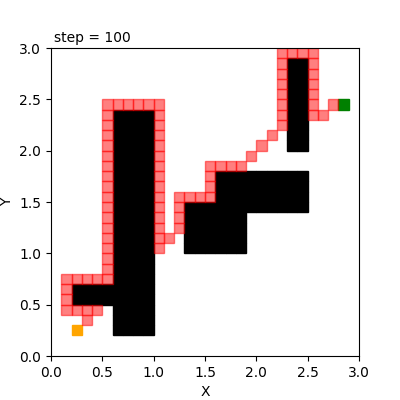

In [3]:
if __name__ == "__main__":
    time_span = 10
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "./csvmap/map7.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(BUG(world))
    
    world.draw()
    #world.ani.save('bug_map.gif', writer='pillow', fps=100)    #アニメーション保存